In [1716]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import cv2

import math
from copy import deepcopy
import array

In [1717]:
### 座標から0~360度の範囲で返す 引数 pos = [x,y]
def pos2deg(pos):
    posh = [i + 0.001 for i in pos]
    deg = math.degrees(math.atan(posh[1]/posh[0]))
    if(posh[0] >= 0 and posh[1] < 0):
        deg += 360
    elif(posh[0] < 0 and posh[1] >= 0):
        deg += 180
    elif(posh[0] < 0 and posh[1] < 0):
        deg += 180
    return deg

In [1718]:
### ポイント[x, y]の配列からpoint以上の数からなる直線を探す {引数} point:[[座標]], min_point:最小ポイント数
def find_line(point, min_point):
    c_point = []
    point2 = [[i, a] for i, a in enumerate(point)]
    #print(point2)
    used_point = [[i] for i in range(len(point2))]
    line_list = []

    for i, x in enumerate(point2): #各ポイントからポイントへの角度を割り出す
        comp = deepcopy(point2)
        comp = [[j[0], j[1]] for j in comp if not(j[0] in used_point[i])] #used_pointのポイントを除外
        relative = np.array([a[1] - x[1] for a in comp])

        #相対角度の計算
        deg = np.array([[[comp[j][0], pos2deg([a[0], a[1]])] for j, a in enumerate(relative)]])
        deg = deg[0][np.argsort(deg[0][:, 1])]
        diff = np.array([abs(deg[i][1] - deg[i+1][1]) for i in range(len(deg)-1)]) #ソートした相対角度を角度の差分値でとる
        #直線であるポイントを探索
        match_count = 0 #直線上のポイント数
        line = [x[0]]
        for a, val in enumerate(diff):
            if(val <= 1.0):# 1.0度以内であれば直線と判断
                if(not(deg[a][0] in line)):
                   line.append(int(deg[a][0]))
                if(not(deg[a + 1][0] in line)):
                   line.append(int(deg[a + 1][0]))
            else:# 満たしてなければ引数条件で直線リストに格納
                if(len(line) >= min_point):
                    for b in line:
                        for c in line:
                            if(not(c in used_point[b])):
                                used_point[b].append(c)
                    line_list.append(line)
                line = [x[0]]
        if(len(line) >= min_point):# 終了時の格納
            for b in line:
                for c in line:
                    if(not(c in used_point[b])):
                        used_point[b].append(c)
            line_list.append(line)
    #推測したポイント番号を座標に変換
    line_pos_list = []
    for i in line_list:
        line_pos = []
        for j in i:
            line_pos.append(point2[j][1])
        line_pos_list.append(line_pos)

    return line_pos_list

In [1719]:
### ラインの中心座標を求める
def line_COG(line_pos_list):
    lpl = deepcopy(line_pos_list)
    x = 0
    y = 0
    line_COG = []
    line_pos_COG = []
    # 各座標から重心を求める
    for i in lpl:
        for j in i:
            x += j[0]
            y += j[1]
        x = x / len(i)
        y = y / len(i)
        # 重心からの距離を求める
        distance = []
        for num, j in enumerate(i):
            distance.append([num, math.sqrt((j[0] - x)**2 + (j[1] - y)**2)])
        distance = sorted(distance, key=lambda x: x[1], reverse=True)

        pos = np.round((i[distance[0][0]] + i[distance[1][0]]) / 2)
        line_COG.append(pos.astype(np.int64))
        line_pos_COG.append([i[distance[0][0]], i[distance[1][0]]])
        #line_COG.append([i[distance[0][0]], i[distance[1][0]]])
    print(lpl)

    return line_COG, line_pos_COG


In [1720]:
### 推測した直線を描画する
def drawline(img, line_pos_list):
    for i in line_pos_list:
        for j in i:
            for k in i:
                cv2.line(img, (j[0], j[1]), (k[0], k[1]), (0, 0, 255))

In [1721]:
### main ###
size = (300, 320)

img_file = "pic.png"
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = cv2.resize(image, dsize=size)
outputImg = image
cv2.imwrite("output.png",image)
height, width, channels = image.shape[:3]

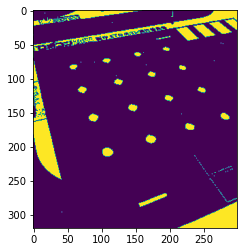

In [1722]:
#image = cv2.blur(image, (3, 3))
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv_min = np.array([0,0,0])
hsv_max = np.array([255,102,255])
mask = cv2.inRange(hsv, hsv_min, hsv_max)
masked_img = cv2.bitwise_and(image, image, mask=mask)

masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

ret, img_thresh = cv2.threshold(masked_img, 1, 255, cv2.THRESH_BINARY_INV)

plt.imshow(np.asarray(img_thresh))

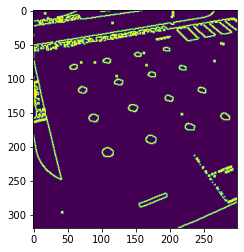

In [1723]:
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = cv2.Canny(img_thresh,50,100)
kernel = np.ones((2,2),np.uint8)
image = cv2.dilate(image,kernel,iterations = 1)

cv2.imwrite("python1.png",image)

plt.imshow(np.asarray(image))

In [1724]:
contours, hierarchy= cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
pointer = [i for i in range(len(contours))] #排除用
len(contours) 

51

In [1725]:
# 輪郭の面積を計算する。
for i in pointer:
    cnt = contours[i]
    area = cv2.contourArea(cnt)
    #print(f"contour: {i}, area: {area}")
    if(not(50 < area and area < 500)):
        pointer[i] = -1

pointer = [i for i in pointer if i != -1] #除外された輪郭を削除



In [1726]:
COG = [] #重心の配列

for i in pointer:
    try:
        cnt = contours[i]
        # 輪郭のモーメントを計算する。
        M = cv2.moments(cnt)
        # モーメントから重心を計算する。
        cx = int(round(M["m10"] / M["m00"],0))
        cy = int(round(M["m01"] / M["m00"],0))
        COG.append([cx, cy])
    except:
        pointer[i] = -1
    print(f"contour: {i}, centroid: ({cx:.2f}, {cy:.2f})")

pointer = [i for i in pointer if i != -1] #除外された輪郭を削除

contour: 1, centroid: (257.00, 301.00)
contour: 2, centroid: (176.00, 279.00)
contour: 3, centroid: (287.00, 276.00)
contour: 12, centroid: (285.00, 234.00)
contour: 16, centroid: (110.00, 208.00)
contour: 17, centroid: (173.00, 189.00)
contour: 18, centroid: (230.00, 171.00)
contour: 19, centroid: (89.00, 158.00)
contour: 21, centroid: (282.00, 156.00)
contour: 22, centroid: (147.00, 143.00)
contour: 23, centroid: (200.00, 129.00)
contour: 24, centroid: (248.00, 117.00)
contour: 25, centroid: (73.00, 117.00)
contour: 26, centroid: (126.00, 105.00)
contour: 29, centroid: (174.00, 94.00)
contour: 30, centroid: (220.00, 84.00)
contour: 32, centroid: (59.00, 83.00)
contour: 37, centroid: (108.00, 74.00)
contour: 39, centroid: (154.00, 65.00)
contour: 40, centroid: (196.00, 57.00)
contour: 42, centroid: (13.00, 54.00)
contour: 43, centroid: (191.00, 41.00)


In [1727]:
COG = np.array(COG)
line_list = find_line(COG, 4)


In [1728]:
line_COG, line_pos_COG = line_COG(line_list)

#print(line_COG)
#print(line_pos_COG)


drawline(outputImg, line_pos_COG)



[[array([110, 208]), array([230, 171]), array([282, 156]), array([173, 189])]]


True

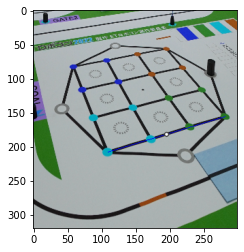

In [1729]:
#推測したサークルポイントを表示させる
#draw_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
for num,i in enumerate(line_COG):
    #cv2.circle(outputImg, i, 3, (0, 255, 0), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    #cv2.circle(outputImg, i, 3, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA, shift=0)

    cv2.circle(outputImg, i, 3, (255, 255, 255), thickness=-1, lineType=cv2.LINE_AA, shift=0)
    cv2.circle(outputImg, i, 3, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA, shift=0)
    #cv2.putText(outputImg, str(num), i, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), thickness=2)

#表示
plt.imshow(np.asarray(outputImg), cmap="binary")
cv2.imwrite("python2.png", outputImg)

In [1730]:
#a = np.array([[i] for i in COG])
#
#approx_contours = []
#arclen = cv2.arcLength(a, True)
## 輪郭を近似する。
#approx_cnt = cv2.approxPolyDP(a, epsilon=0.001 * arclen, closed=True)
#approx_contours.append(approx_cnt)
## 元の輪郭及び近似した輪郭の点の数を表示する。
#print(f"contour {i}: before: {len(a)}, after: {len(approx_cnt)}")


In [1731]:
#circleSize = 2
#cimg = Image.open("output.png")
#draw = ImageDraw.Draw(cimg)
#for i in approx_cnt:
#    draw.ellipse([i[0][0]-circleSize, i[0][1]-circleSize, i[0][0]+circleSize, i[0][1]+circleSize], width=1, outline="black", fill="white")
#
##表示
#plt.imshow(np.asarray(cimg), cmap="binary")